In [1]:
%%capture
!pip install gymnasium[classic-control]

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

Setting up plotting and environment...
Starting Q-Learning training...
--- Snapshot saved at episode 10 ---
--- Snapshot saved at episode 100 ---
--- Snapshot saved at episode 1000 ---
Episode: 5000 | Epsilon: 0.600
Episode: 10000 | Epsilon: 0.200
Episode: 15000 | Epsilon: -0.000
Episode: 20000 | Epsilon: -0.000
Episode: 25000 | Epsilon: -0.000
--- Snapshot saved at episode 25000 ---

--- Training Finished ---
Total training time: 210.67 seconds
Displaying plots... Close the plot window to finish.


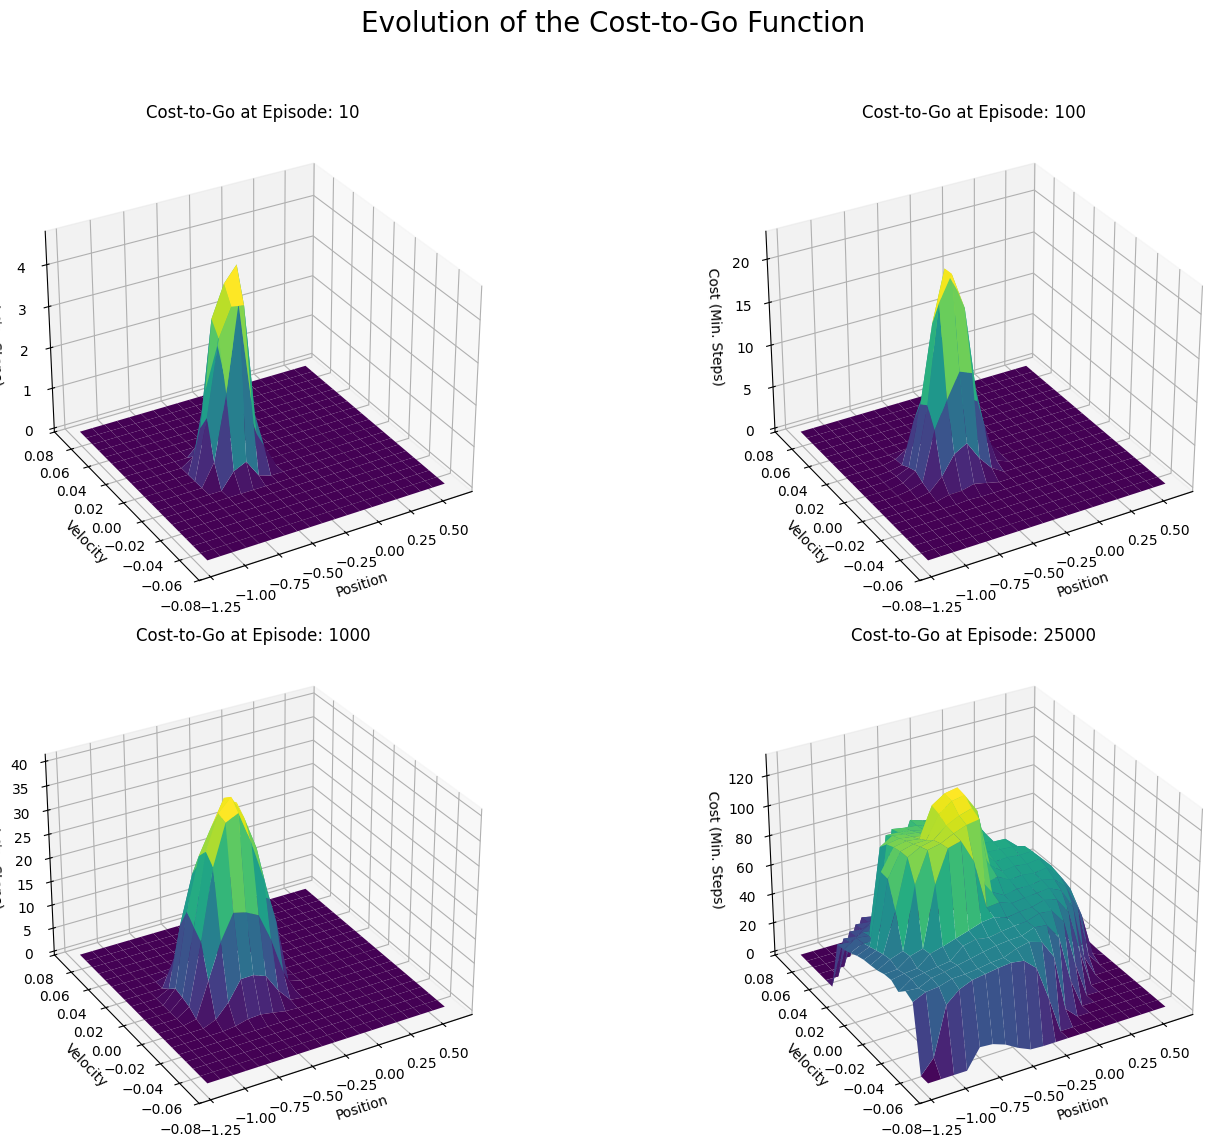


--- Demonstrating Final Policy (1 episode) ---
Demonstration finished.


In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

print("Setting up plotting and environment...")

def plot_cost_to_go(plot_data, env, discrete_os_size):
    """
    Generates 3D surface plots for the cost-to-go function
    at the specified episodes.
    """
    # Create the X (position) and Y (velocity) axes for the plot
    pos_axis = np.linspace(
        env.observation_space.low[0],
        env.observation_space.high[0],
        discrete_os_size[0]
    )
    vel_axis = np.linspace(
        env.observation_space.low[1],
        env.observation_space.high[1],
        discrete_os_size[1]
    )

    # Create a meshgrid for the 3D plot
    X, Y = np.meshgrid(pos_axis, vel_axis)

    # We need a 2x2 grid for our 4 plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': '3d'})
    axes = axes.flatten()

    plot_keys = sorted(plot_data.keys())

    for i, episode_num in enumerate(plot_keys):
        ax = axes[i]

        # Get the saved cost-to-go data
        Z = plot_data[episode_num]

        # plot_surface needs X, Y, Z.
        # Our Q-table is indexed (pos, vel), but meshgrid creates
        # X (pos) and Y (vel) where the first index maps to Y
        # and the second to X. We must transpose Z to align them.
        ax.plot_surface(X, Y, Z.T, cmap='viridis')

        ax.set_title(f"Cost-to-Go at Episode: {episode_num}")
        ax.set_xlabel("Position")
        ax.set_ylabel("Velocity")
        ax.set_zlabel("Cost (Min. Steps)")
        ax.view_init(elev=30, azim=-120) # Adjust view angle

    plt.suptitle("Evolution of the Cost-to-Go Function", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    print("Displaying plots... Close the plot window to finish.")
    plt.show()


# --- Main RL Script ---

# 1. Initialize the environment
env = gym.make("MountainCar-v0")

# --- Hyperparameters ---
LEARNING_RATE = 0.1  # alpha
# User request: Discount rate = 1
DISCOUNT = 1.0       # gamma
EPISODES = 25000     # Total episodes to train
SHOW_EVERY = 5000    # Print progress

# Epsilon (exploration) settings
epsilon = 1.0
EPSILON_START_DECAY = 1
EPSILON_END_DECAY = EPISODES // 2
epsilon_decay_value = epsilon / (EPSILON_END_DECAY - EPSILON_START_DECAY)

# --- Discretization ---
DISCRETE_OS_SIZE = [20, 20] # 20 bins for position, 20 for velocity
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE

# Initialize the Q-table
q_table = np.zeros((DISCRETE_OS_SIZE[0], DISCRETE_OS_SIZE[1], env.action_space.n))

# Helper to get discrete state
def get_discrete_state(state):
    state_np = np.array(state)
    discrete_state = (state_np - env.observation_space.low) / discrete_os_win_size
    return tuple(discrete_state.astype(int))

# Dictionary to store Q-tables for plotting
plot_data = {}
# Episodes we want to capture for plotting
plot_episodes = [10, 100, 1000, EPISODES]


print("Starting Q-Learning training...")
start_time = time.time()

# 2. Training Loop
for episode in range(1, EPISODES + 1):
    state, _ = env.reset()
    discrete_state = get_discrete_state(state)

    terminated = False
    truncated = False

    while not terminated and not truncated:
        # Epsilon-greedy action selection
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state])
        else:
            action = env.action_space.sample()

        # Take the action
        # User request: Reward is -1 on all steps
        new_state, reward, terminated, truncated, _ = env.step(action)
        new_discrete_state = get_discrete_state(new_state)

        # --- Q-Learning Update ---
        if not terminated:
            current_q = q_table[discrete_state + (action,)]
            max_future_q = np.max(q_table[new_discrete_state])

            # The Q-learning update rule
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        # If the agent reached the goal
        else:
            # Set Q-value for the goal state to 0 (no future cost)
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state

    # Decay epsilon
    if EPSILON_END_DECAY >= episode >= EPSILON_START_DECAY:
        epsilon -= epsilon_decay_value

    # Print progress
    if episode % SHOW_EVERY == 0:
        print(f"Episode: {episode} | Epsilon: {epsilon:.3f}")

    # --- Save data for plotting ---
    if episode in plot_episodes:
        # We save the cost-to-go: -max_a Q(s, a)
        cost_to_go = -np.max(q_table, axis=2)
        plot_data[episode] = cost_to_go.copy() # Save a copy
        print(f"--- Snapshot saved at episode {episode} ---")


env.close()
end_time = time.time()
print(f"\n--- Training Finished ---")
print(f"Total training time: {end_time - start_time:.2f} seconds")

# 3. Generate the plots
plot_cost_to_go(plot_data, env, DISCRETE_OS_SIZE)


# 4. Demonstrate the final policy
print("\n--- Demonstrating Final Policy (1 episode) ---")
env_render = gym.make("MountainCar-v0", render_mode="human")
state, _ = env_render.reset()
discrete_state = get_discrete_state(state)
terminated = False
truncated = False

while not terminated and not truncated:
    action = np.argmax(q_table[discrete_state])
    new_state, _, terminated, truncated, _ = env_render.step(action)
    discrete_state = get_discrete_state(new_state)

print("Demonstration finished.")
env_render.close()

In [4]:
import gymnasium as gym
import numpy as np
from collections import deque
import time

# --- Convergence Criterion ---
CONVERGENCE_THRESHOLD = -110.0         # Avg reward to consider "solved"
CONSECUTIVE_EPISODES_FOR_AVG = 100     # Number of episodes to average over

# --- Hyperparameters ---
LEARNING_RATE = 0.1
# Per your request, discount rate = 1.0
DISCOUNT = 1.0
MAX_EPISODES = 100000 # A safety cap to prevent infinite loops

# Epsilon (exploration) settings
epsilon = 1.0
EPSILON_START_DECAY = 1
EPSILON_END_DECAY = MAX_EPISODES // 2 # Decay over first half of max episodes
epsilon_decay_value = epsilon / (EPSILON_END_DECAY - EPSILON_START_DECAY)

# --- Discretization ---
DISCRETE_OS_SIZE = [20, 20] # Position and velocity bins

# --- Environment Setup ---
env = gym.make("MountainCar-v0")
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE

# Initialize Q-table
q_table = np.zeros((DISCRETE_OS_SIZE[0], DISCRETE_OS_SIZE[1], env.action_space.n))

# Helper to get discrete state
def get_discrete_state(state):
    state_np = np.array(state)
    discrete_state = (state_np - env.observation_space.low) / discrete_os_win_size
    return tuple(discrete_state.astype(int))

# Function to run the animation after training

def run_animation(trained_q_table):
    print("\n--- Running Simulation of Final Policy ---")

    # Create a new env with 'human' render mode
    env_render = gym.make("MountainCar-v0", render_mode="human")
    state, _ = env_render.reset()
    terminated = False
    truncated = False

    while not terminated and not truncated:
        # Get discrete state
        discrete_state = get_discrete_state(state)

        # Take the BEST action from the Q-table (no exploration)
        action = np.argmax(trained_q_table[discrete_state])

        # Step the environment
        new_state, _, terminated, truncated, _ = env_render.step(action)
        state = new_state

    print("Simulation finished.")
    env_render.close()

# --- Main Training Loop ---
print(f"Starting training... Will stop when avg. reward over 100 episodes >= {CONVERGENCE_THRESHOLD}")
start_time = time.time()

# Use a deque to efficiently store the last 100 rewards
episode_rewards = deque(maxlen=CONSECUTIVE_EPISODES_FOR_AVG)
converged = False
total_episodes_to_converge = 0

for episode in range(1, MAX_EPISODES + 1):
    state, _ = env.reset()
    discrete_state = get_discrete_state(state)

    terminated = False
    truncated = False
    episode_reward = 0

    while not terminated and not truncated:
        # Epsilon-greedy action selection
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state])
        else:
            action = env.action_space.sample()

        new_state, reward, terminated, truncated, _ = env.step(action)
        new_discrete_state = get_discrete_state(new_state)
        episode_reward += reward # Per your request, reward is -1

        # Q-Learning Update
        if not terminated:
            current_q = q_table[discrete_state + (action,)]
            max_future_q = np.max(q_table[new_discrete_state])

            # Q-learning update with DISCOUNT=1.0
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        else:
            # Goal state has a Q-value of 0
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state

    # End of episode

    # Decay epsilon
    if EPSILON_END_DECAY >= episode >= EPSILON_START_DECAY:
        epsilon -= epsilon_decay_value

    # Add episode reward to our deque
    episode_rewards.append(episode_reward)

    # Print progress
    if episode % 1000 == 0:
        avg_reward = np.mean(episode_rewards)
        print(f"Episode: {episode} | Avg. Reward (last 100): {avg_reward:.2f} | Epsilon: {epsilon:.3f}")

    # --- Check for Convergence ---
    if len(episode_rewards) == CONSECUTIVE_EPISODES_FOR_AVG:
        avg_reward = np.mean(episode_rewards)
        if avg_reward >= CONVERGENCE_THRESHOLD:
            end_time = time.time()
            total_episodes_to_converge = episode
            converged = True
            print("\n" + "="*40)
            print(f"TASK SOLVED!")
            print(f"Converged in {total_episodes_to_converge} episodes.")
            print(f"Final Avg. Reward (last 100): {avg_reward:.2f}")
            print(f"Total training time: {end_time - start_time:.2f} seconds")
            print("="*40)
            break # Exit the training loop

env.close()

if not converged:
    print(f"\nFailed to converge within {MAX_EPISODES} episodes.")
    print(f"Final Avg. Reward (last 100): {np.mean(episode_rewards):.2f}")

# --- Show the Final Animation ---
run_animation(q_table)

Starting training... Will stop when avg. reward over 100 episodes >= -110.0
Episode: 1000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.980
Episode: 2000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.960
Episode: 3000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.940
Episode: 4000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.920
Episode: 5000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.900
Episode: 6000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.880
Episode: 7000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.860
Episode: 8000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.840
Episode: 9000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.820
Episode: 10000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.800
Episode: 11000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.780
Episode: 12000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.760
Episode: 13000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.740
Episode: 14000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.720
Episode: 

In [7]:
run_animation(q_table)


--- Running Simulation of Final Policy ---
Simulation finished.


In [7]:
import gymnasium as gym
import numpy as np
from collections import deque
import time
import pathlib

# --- We need moviepy to save the animations ---
try:
    from moviepy.editor import ImageSequenceClip
except ImportError:
    print("Error: moviepy not found.")
    print("Please install it with: pip install moviepy")
    exit()

print("Setting up, this will take a few minutes...")

# --- Output Directory ---
ANIMATION_DIR = pathlib.Path("./mountain_car_animations")
ANIMATION_DIR.mkdir(exist_ok=True)

# --- Hyperparameters & Convergence ---
LEARNING_RATE = 0.1
DISCOUNT = 1.0
MAX_EPISODES = 20000 # We'll use a slightly shorter max for this demo
CONVERGENCE_THRESHOLD = -110.0
CONSECUTIVE_EPISODES_FOR_AVG = 100

# --- Episodes to save snapshots ---
SNAPSHOT_EPISODES = [10, 100, 1000]
q_table_snapshots = {} # Dict to store the Q-tables

# Epsilon (exploration) settings
epsilon = 1.0
EPSILON_START_DECAY = 1
EPSILON_END_DECAY = MAX_EPISODES // 2
epsilon_decay_value = epsilon / (EPSILON_END_DECAY - EPSILON_START_DECAY)

# --- Discretization ---
DISCRETE_OS_SIZE = [20, 20] # Position and velocity bins

# --- Environment Setup (No render mode for fast training) ---
env = gym.make("MountainCar-v0")
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE

# Initialize Q-table
q_table = np.zeros((DISCRETE_OS_SIZE[0], DISCRETE_OS_SIZE[1], env.action_space.n))

# Helper to get discrete state
def get_discrete_state(state):
    state_np = np.array(state)
    discrete_state = (state_np - env.observation_space.low) / discrete_os_win_size
    # Clip values to be within Q-table bounds
    discrete_state = np.clip(
        discrete_state,
        a_min=0,
        a_max=np.array(DISCRETE_OS_SIZE) - 1
    )
    return tuple(discrete_state.astype(int))

# NEW FUNCTION: Runs one episode and saves it as a GIF

def save_animation(q_table_to_run, filename, fps=30):
    """Runs one episode with the given Q-table and saves it as a GIF."""
    print(f"  ...Generating {filename}...")

    # Create a new env in "rgb_array" mode
    anim_env = gym.make("MountainCar-v0", render_mode="rgb_array")
    state, _ = anim_env.reset()

    frames = [anim_env.render()] # Add the very first frame
    terminated = False
    truncated = False

    while not terminated and not truncated:
        discrete_state = get_discrete_state(state) # Use current state
        action = np.argmax(q_table_to_run[discrete_state]) # Get best action

        # Take the step
        new_state, _, terminated, truncated, _ = anim_env.step(action)

        # Add the new frame to our list
        frames.append(anim_env.render())
        state = new_state # Update state for next loop iteration

    anim_env.close()

    # Use moviepy to create and save the GIF
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_gif(str(filename), logger=None) # logger=None to suppress console spam


# --- Main Training Loop ---
print(f"Starting training... Will save snapshots at episodes: {SNAPSHOT_EPISODES}")
start_time = time.time()

episode_rewards = deque(maxlen=CONSECUTIVE_EPISODES_FOR_AVG)
converged = False

for episode in range(1, MAX_EPISODES + 1):
    state, _ = env.reset()
    discrete_state = get_discrete_state(state)

    terminated = False
    truncated = False
    episode_reward = 0

    while not terminated and not truncated:
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state])
        else:
            action = env.action_space.sample()

        new_state, reward, terminated, truncated, _ = env.step(action)
        new_discrete_state = get_discrete_state(new_state)
        episode_reward += reward

        # Q-Learning Update
        if not terminated:
            current_q = q_table[discrete_state + (action,)]
            max_future_q = np.max(q_table[new_discrete_state])
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q
        else:
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state

    # --- End of episode ---

    # Decay epsilon
    if EPSILON_END_DECAY >= episode >= EPSILON_START_DECAY:
        epsilon -= epsilon_decay_value

    episode_rewards.append(episode_reward)

    # Check for convergence
    if not converged and len(episode_rewards) == CONSECUTIVE_EPISODES_FOR_AVG:
        avg_reward = np.mean(episode_rewards)
        if avg_reward >= CONVERGENCE_THRESHOLD:
            converged = True
            end_time = time.time()
            print("\n" + "="*40)
            print(f"TASK SOLVED! Converged at episode {episode}")
            print(f"Total training time: {end_time - start_time:.2f} seconds")
            print("="*40)
            # Save this converged Q-table as the "final" one
            q_table_snapshots["final_converged"] = q_table.copy()

    # --- Save Q-table snapshots ---
    if episode in SNAPSHOT_EPISODES:
        q_table_snapshots[episode] = q_table.copy()
        print(f"--- Snapshot of Q-table saved at episode {episode} ---")

# If it never converged, just save the last Q-table
if "final_converged" not in q_table_snapshots:
    q_table_snapshots["final_unconverged"] = q_table.copy()

env.close()
print("\n--- Training Finished ---")


# --- Generate and Save All Animations ---
print(f"\n--- Generating Animations ---")
print(f"Files will be saved in: {ANIMATION_DIR.resolve()}")

for episode_num, snapshot_q in q_table_snapshots.items():
    filename = ANIMATION_DIR / f"mountain_car_ep_{episode_num}.gif"
    save_animation(snapshot_q, filename)

print("\nAll animations saved successfully!")

Setting up, this will take a few minutes...
Starting training... Will save snapshots at episodes: [10, 100, 1000]
--- Snapshot of Q-table saved at episode 10 ---
--- Snapshot of Q-table saved at episode 100 ---
--- Snapshot of Q-table saved at episode 1000 ---

--- Training Finished ---

--- Generating Animations ---
Files will be saved in: /content/mountain_car_animations
  ...Generating mountain_car_animations/mountain_car_ep_10.gif...
  ...Generating mountain_car_animations/mountain_car_ep_100.gif...
  ...Generating mountain_car_animations/mountain_car_ep_1000.gif...
  ...Generating mountain_car_animations/mountain_car_ep_final_unconverged.gif...

All animations saved successfully!


Setting up environment and parameters...
Starting training... Will stop when avg. reward over 100 episodes >= -110.0
Episode: 1000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.960
Episode: 2000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.920
Episode: 3000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.880
Episode: 4000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.840
Episode: 5000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.800
Episode: 6000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.760
Episode: 7000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.720
Episode: 8000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.680
Episode: 9000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.640
Episode: 10000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.600
Episode: 11000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.560
Episode: 12000 | Avg. Reward (last 100): -200.00 | Epsilon: 0.520
Episode: 13000 | Avg. Reward (last 100): -199.55 | Epsilon: 0.480
Episode: 14000 | Avg. Reward (last

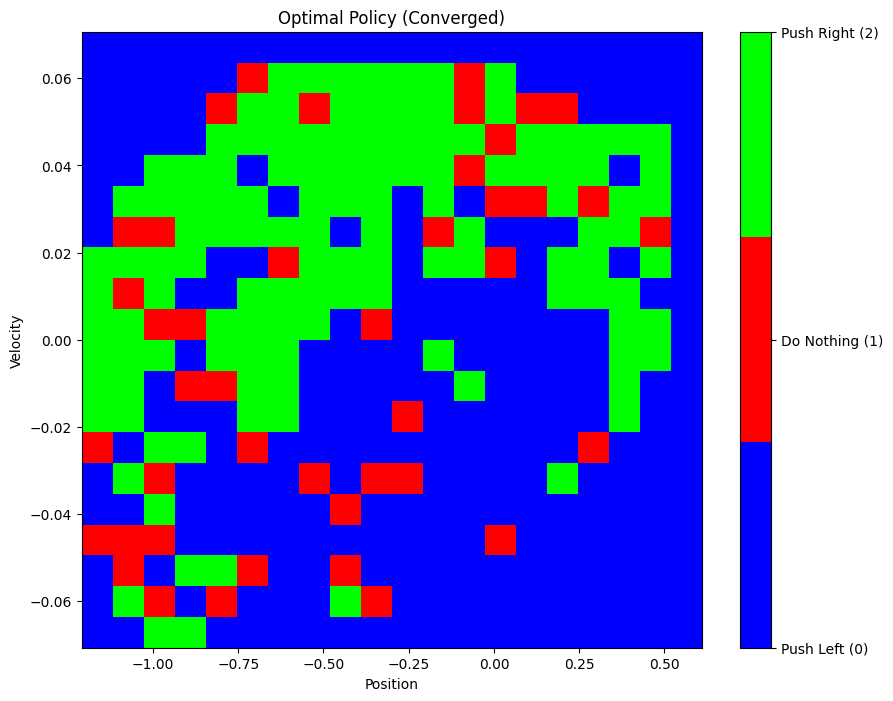


--- Running Simulation of Final Policy ---
Simulation finished.


In [8]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import deque
import time

print("Setting up environment and parameters...")

# --- Convergence Criterion ---
CONVERGENCE_THRESHOLD = -110.0         # Avg reward to consider "solved"
CONSECUTIVE_EPISODES_FOR_AVG = 100     # Number of episodes to average over

# --- Hyperparameters ---
LEARNING_RATE = 0.1
DISCOUNT = 1.0       # Per your request
MAX_EPISODES = 50000 # Safety cap

# Epsilon (exploration) settings
epsilon = 1.0
EPSILON_START_DECAY = 1
EPSILON_END_DECAY = MAX_EPISODES // 2
epsilon_decay_value = epsilon / (EPSILON_END_DECAY - EPSILON_START_DECAY)

# --- Discretization ---
# A finer grid gives a nicer plot, but trains slightly slower.
# 20x20 is a good balance.
DISCRETE_OS_SIZE = [20, 20] # Position and velocity bins

# --- Environment Setup ---
env = gym.make("MountainCar-v0")
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE

# Initialize Q-table
q_table = np.zeros((DISCRETE_OS_SIZE[0], DISCRETE_OS_SIZE[1], env.action_space.n))

# Helper to get discrete state
def get_discrete_state(state):
    state_np = np.array(state)
    discrete_state = (state_np - env.observation_space.low) / discrete_os_win_size

    # We need to clip the values to be within the bounds of our Q-table
    # (e.g., if velocity is slightly out of bounds)
    discrete_state = np.clip(
        discrete_state,
        a_min=0,
        a_max=np.array(DISCRETE_OS_SIZE) - 1
    )
    return tuple(discrete_state.astype(int))

# Function to plot the 2D optimal policy

def plot_optimal_policy(q_table, env, discrete_os_size):
    print("Generating optimal policy plot...")

    # Create a grid of points spanning the entire state space
    pos_space = np.linspace(
        env.observation_space.low[0],
        env.observation_space.high[0],
        100 # Generate 100 points for position
    )
    vel_space = np.linspace(
        env.observation_space.low[1],
        env.observation_space.high[1],
        100 # Generate 100 points for velocity
    )

    # This 2D array will store the optimal action for each (pos, vel) pair
    policy_grid = np.zeros((len(pos_space), len(vel_space)))

    for i, pos in enumerate(pos_space):
        for j, vel in enumerate(vel_space):
            # Get the discrete state for this (pos, vel) pair
            state = (pos, vel)
            discrete_state = get_discrete_state(state)

            # Find the optimal action from the Q-table
            action = np.argmax(q_table[discrete_state])
            policy_grid[i, j] = action

    # --- Plotting ---

    # Create a custom colormap: 0=Blue (Left), 1=Red (Nothing), 2=Green (Right)
    # This matches the colors in your example image
    cmap = ListedColormap(['blue', 'red', 'lime'])

    plt.figure(figsize=(10, 8))

    # Use pcolormesh for a clean, non-aliased plot
    # Note: We plot policy_grid.T (transpose) because
    # pcolormesh expects (x, y, data) where data[y, x]
    plt.pcolormesh(pos_space, vel_space, policy_grid.T, cmap=cmap, shading='auto')

    plt.title("Optimal Policy (Converged)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")

    # Create a legend
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Push Left (0)', 'Do Nothing (1)', 'Push Right (2)'])

    print("Displaying policy plot... Close the window to run the simulation.")
    plt.show()


# Function to run the animation after training

def run_animation(trained_q_table):
    print("\n--- Running Simulation of Final Policy ---")

    env_render = gym.make("MountainCar-v0", render_mode="human")
    state, _ = env_render.reset()
    terminated = False
    truncated = False

    while not terminated and not truncated:
        discrete_state = get_discrete_state(state)
        action = np.argmax(trained_q_table[discrete_state])
        new_state, _, terminated, truncated, _ = env_render.step(action)
        state = new_state

    print("Simulation finished.")
    env_render.close()

# --- Main Training Loop ---
print(f"Starting training... Will stop when avg. reward over 100 episodes >= {CONVERGENCE_THRESHOLD}")
start_time = time.time()

episode_rewards = deque(maxlen=CONSECUTIVE_EPISODES_FOR_AVG)
converged = False
total_episodes_to_converge = 0

for episode in range(1, MAX_EPISODES + 1):
    state, _ = env.reset()
    discrete_state = get_discrete_state(state)

    terminated = False
    truncated = False
    episode_reward = 0

    while not terminated and not truncated:
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state])
        else:
            action = env.action_space.sample()

        new_state, reward, terminated, truncated, _ = env.step(action)
        new_discrete_state = get_discrete_state(new_state)
        episode_reward += reward

        # Q-Learning Update
        if not terminated:
            current_q = q_table[discrete_state + (action,)]
            max_future_q = np.max(q_table[new_discrete_state])
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q
        else:
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state

    # End of episode
    if EPSILON_END_DECAY >= episode >= EPSILON_START_DECAY:
        epsilon -= epsilon_decay_value

    episode_rewards.append(episode_reward)

    if episode % 1000 == 0:
        avg_reward = np.mean(episode_rewards) if len(episode_rewards) > 0 else -200
        print(f"Episode: {episode} | Avg. Reward (last 100): {avg_reward:.2f} | Epsilon: {epsilon:.3f}")

    # Check for Convergence
    if len(episode_rewards) == CONSECUTIVE_EPISODES_FOR_AVG:
        avg_reward = np.mean(episode_rewards)
        if avg_reward >= CONVERGENCE_THRESHOLD:
            end_time = time.time()
            total_episodes_to_converge = episode
            converged = True
            print("\n" + "="*40)
            print(f"TASK SOLVED!")
            print(f"Converged in {total_episodes_to_converge} episodes.")
            print(f"Total training time: {end_time - start_time:.2f} seconds")
            print("="*40)
            break

env.close()

if not converged:
    print(f"\nFailed to converge within {MAX_EPISODES} episodes.")

# --- Run the visualization functions ---

# 1. Plot the policy map
plot_optimal_policy(q_table, env, DISCRETE_OS_SIZE)

# 2. Show the policy in action
run_animation(q_table)